# Problem Set 4 Solutions
In this problem set you will get some practice with the proximal gradient algorithm, and also acceleration. Specifically, you will be implementing ISTA and FISTA.

# Problem 1: Gradient Descent and Acceleration
In this problem you will explore the impact of ill-conditioning on gradient descent, and will then see how acceleration can improve the situation. This exercise will walk you through a very similar situation as to what we saw in the lecture videos that illustrate the performance of gradient descent vs accelerated gradient descent as the condition number (ratio of largest to smallest eigenvalues of the Hessian) increases. This is a ``toy'' problem, but it is still instructive regarding the performance of these two algorithms.

You will work with the following simple function:
$$
f(x) = \frac{1}{2}x^{\top}Qx,
$$
where $Q$ is a 2 by 2 matrix, as defined below.

In [ ]:
import numpy as np

# We create the data for this simple problem. We will create three quadratics.
# Q_wc -- this is a well-conditioned matrix
# Q_ic -- this is an ill-conditioned matrix
# Q_sic -- this is... a somewhat-ill-conditioned matrix (a technical term!)

Q_wc = np.array([[1,0.3],[0.3,1]]); q = np.array([0,0]);
Q_sic = np.array([[1,0.85],[0.85,1]]); q = np.array([0,0]);
Q_ic = np.array([[1,0.99],[0.99,1]]); q = np.array([0,0]);


In [ ]:
la.eig(Q_wc)

(array([1.3, 0.7]), array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))

## Part (A):
Consider the quadratic functions $f_{wc}$, $f_{sic}$, and $f_{ic}$ defined by the quadratic matrices above. For each of these, say whether they are $\beta$-smooth and/or $\alpha$-strongly convex, and if so, compute the value of the condition number, $\kappa = \beta/\alpha$ for each function.

$f$ is twice differential, where $\nabla^2f = Q$. Now we use the Hessian properties to determine the $\alpha$ and $\beta$ terms for each function:

$$\alpha = \lambda_{min}(Q), \beta = \lambda_{max}(Q), \kappa = \frac{\lambda_{max}(Q)}{\lambda_{min}(Q)}$$

In [ ]:
import numpy.linalg as la
import time
import matplotlib.pyplot as plt
import numpy.random as rn
import csv
import pdb

%matplotlib inline

In [ ]:
#Q_wc
a, b = la.eigvals(Q_wc).min(),  la.eigvals(Q_wc).max()
k = b/a
print(f'Q_wc: a={0.3},b={b:0.3f},k={k:0.3f}')

#Q_sic
a, b = la.eigvals(Q_sic).min(),  la.eigvals(Q_sic).max()
k = b/a
print(f'Q_sic: a={0.3},b={b:0.3f},k={k:0.3f}')

#Q_ic
a, b = la.eigvals(Q_ic).min(),  la.eigvals(Q_ic).max()
k = b/a
print(f'Q_ic: a={0.3},b={b:0.3f},k={k:0.3f}')

Q_wc: a=0.3,b=1.300,k=1.857
Q_sic: a=0.3,b=1.850,k=12.333
Q_ic: a=0.3,b=1.990,k=199.000


## Part (B):
Compute the best fixed step size for gradient descent, and the best parameters for accelerated gradient descent. For each function, plot the error $(f(x_t) - f(x^{\ast})$ as a function of the number of iterations. For each function, plot these on the same plot so you can compare -- so you should have 3 plots total.

$f$ is smooth and strongly convex, giving us an optimal step size of $\eta = \frac{2}{\alpha + \beta}$

In [ ]:
#optimal value is 0 for this simple problem
f_star = 0

def descent_p1(update, Q, T=int(1e3)):
  x = 2*np.ones(Q.shape[1])
  error = []
  elapsed_time = []
  start=time.time()
  for t in range(T):
    x = update(x, Q, t)
    end=time.time()
    if (t % 1 == 0) or (t == T - 1):
      error.append(.5 * np.dot(x.T, np.dot(Q, x)))
      elapsed_time.append(end-start)
      assert not np.isnan(error[-1])
  return x, error

def gd(x, Q, t):
  grad = np.dot(Q, x)
  a, b = la.eigvals(Q).min(),  la.eigvals(Q).max()
  eta = 2 / (a + b)
  y=x-eta*grad
  x=y
  return x

def agd(x, Q, t):
  if t == 0:
    #initialize a static variable to remember previous value of y
    agd.y_old = x

  grad = np.dot(Q, x)
  a, b = la.eigvals(Q).min(),  la.eigvals(Q).max()
  k = b/a
  eta = 1 / b

  y_new = x - eta*grad
  k_term = (np.sqrt(k) - 1) / (np.sqrt(k) + 1)
  x = (1 + k_term)*y_new - k_term * agd.y_old
  agd.y_old = y_new

  return x

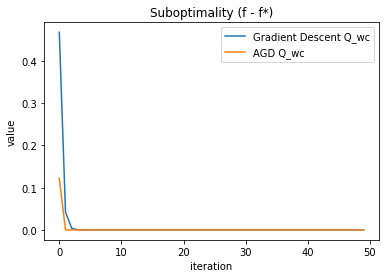

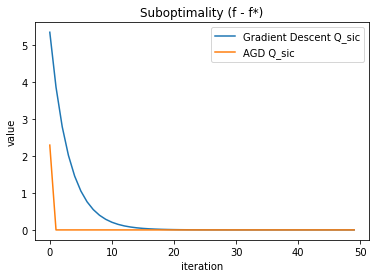

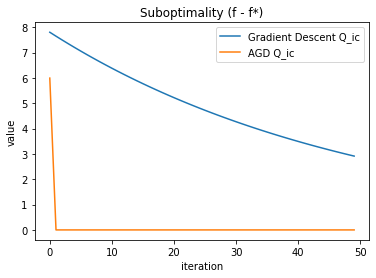

In [ ]:
T=int(50)

R, lam = 5., 1e-6

x_g, error_g = descent_p1(gd, Q_wc, T=T)
x_agd, error_agd = descent_p1(agd, Q_wc, T=T)

# x-axis is iteration
fig=plt.figure()
plt.plot(error_g, label='Gradient Descent Q_wc')
plt.plot(error_agd, label='AGD Q_wc')
plt.title('Suboptimality (f - f*)')
plt.xlabel('iteration')
plt.ylabel('value')
plt.legend()
plt.show()

x_g, error_g = descent_p1(gd, Q_sic, T=T)
x_agd, error_agd = descent_p1(agd, Q_sic, T=T)

# x-axis is iteration
fig=plt.figure()
plt.plot(error_g, label='Gradient Descent Q_sic')
plt.plot(error_agd, label='AGD Q_sic')
plt.title('Suboptimality (f - f*)')
plt.xlabel('iteration')
plt.ylabel('value')
plt.legend()
plt.show()

x_g, error_g = descent_p1(gd, Q_ic, T=T)
x_agd, error_agd = descent_p1(agd, Q_ic, T=T)

# x-axis is iteration
fig=plt.figure()
plt.plot(error_g, label='Gradient Descent Q_ic')
plt.plot(error_agd, label='AGD Q_ic')
plt.title('Suboptimality (f - f*)')
plt.xlabel('iteration')
plt.ylabel('value')
plt.legend()
plt.show()

# Problem 2: ISTA and FISTA
Recall the least squares problem with $\ell^1$ regularization from the previous homework:
$$
\min_x \left[f(x) = \frac{1}{2}\|{Ax-b}\|_2^2 + \lambda \|{x}\|_1 \right]
$$

Recall key characteristics of this problem: it is nonsmooth due to the regularization term, and it is not strongly convex when $A$ has more columns than rows. This is why you used the sub-gradient method on the previous problem set, rather than Gradient descent.

Recall the goal of the proximal gradient algorithm: when we have a composite function, i.e., a function of the form $f(x) = g(x) + h(x)$, if $g(x)$ is $\beta$-smooth and $h(x)$ is ``simple'' in the sense that it has a simple prox function, then rather than using the subgradient method, we can get much better results by using proximal gradient, which takes advantage of the fact that $g(x)$ is smooth. We can improve this further by combining the proximal gradient method with acceleration.

Using the same data (same $A$ and $b$) as in Problem Set 3, minimize $f(x)$ using $10^4$ iterations with $t=0$ and $x_0 =0$.

Use the proximal gradient algorithm, also known as ISTA for the case where $f$ is the LASSO objective. Now use the accelerated proximal gradient algorithm, also, known as FISTA. Plot these results on the same plot as your results for sub-gradient descent from the previous lecture.

In [ ]:
def descent_p2(algo,func,grad,hess,train,test,params,linesearch):
    var=params.initvar
    numtr=train.X.shape[0]
    numte=test.X.shape[0]
    loss,reg,te_error,elapsed_time=[],[],[],[]
    start=time.time()
    for it in range(params.max_iter):
        var = algo(var,train,func,grad,hess,linesearch,it,params)
        end=time.time()
        beta,gamma = var.beta,var.gamma
        loss.append(func(gamma,train,params,numtr)[0])
        reg.append(func(gamma,train,params,numtr)[1])
        te_error.append(func(gamma,test,params,numte)[0])
        elapsed_time.append(end-start)
    return beta,loss,reg,te_error,elapsed_time

def plotresult(loss,algo,params,marker,title,ylabel=' ',xlabel=' ',yscale='linear',isSave=False,filename=None,ylim=None,xlim=None):
    fig=plt.figure()
    for i in range(len(loss)):
        plt.plot(loss[i], label=algo[i],marker=marker[i],markevery=int((params.max_iter)/10))
    plt.title(title)
    plt.yscale(yscale)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    if isSave:
        plt.savefig(filename)
    plt.show()

In [ ]:
# algorithms
def ista(var,data,func,grad,hess,linesearch,iter,params):
    numpts=params.numpts
    beta=var.beta
    reg=params.reg
    desc=-grad(beta,data,params,numpts)[0]
    eta=params.stepsize
    beta=beta+eta*desc
    beta=np.sign(beta)*np.maximum(abs(beta)-reg*eta,0)
    var=Variable(beta,beta,0)
    return var

def fista(var,data,func,grad,hess,linesearch,iter,params):
    numpts=params.numpts
    beta,gamma,tau=var.beta,var.gamma,var.tau
    reg=params.reg
    tau_old=tau
    tau=(1+np.sqrt(1+4*np.square(tau)))/2
    ratio=(1-tau_old)/tau
    beta_old=beta
    gamma_old=gamma
    desc=-grad(beta,data,params,numpts)[0]
    eta=params.stepsize
    gamma=beta+eta*desc
    gamma=np.sign(gamma)*np.maximum(abs(gamma)-reg*eta,0)
    beta=(1-ratio)*gamma+ratio*(gamma_old)
    var=Variable(beta,gamma,tau)
    return var

def gd(var,data,func,grad,hess,linesearch,iter,params):
    numpts=params.numpts
    beta=var.beta
    desc=-np.sum(grad(beta,data,params,numpts),axis=0)
    eta=linesearch(beta,func,grad,desc,data,params,iter)
    beta=beta+eta*desc
    var=Variable(beta,beta,0)
    return var

#linesearch
def btls(beta,func,grad,desc,data,params,iter):
    a,b=params.a,params.b
    ndata=data.X.shape[0]
    t=1
    while np.sum(func(beta+t*desc,data,params,ndata))>np.sum(func(beta,data,params,ndata))+a*t*np.dot(np.sum(grad(beta,data,params,ndata),axis=0).T,desc):
        t=b*t
    return t
def constantstep(beta,func,grad,desc,data,params,iter):
    return params.stepsize
def fixedstep1(beta,func,grad,desc,data,params,iter):
    return params.stepsize/(iter+1)
def fixedstep2(beta,func,grad,desc,data,params,iter):
    return params.stepsize/np.sqrt(iter+1)



In [ ]:
# classes
class Parameter:
    def __init__(self,initbeta,initvar):
        self.initbeta=initbeta
        self.initvar=initvar
class Data:
    def __init__(self,X,Y):
        self.X=X
        self.Y=Y
class Variable:
    def __init__(self,beta,gamma,tau):
        self.beta=beta
        self.gamma=gamma
        self.tau=tau

# functions and gradients
# Linear regression
def func_linreg(beta,data,params,numpts):
    n,d=data.X.shape
    if numpts==n:
        X,Y=data.X,data.Y
        loss=(1./Y.shape[0])*(.5)*np.sum((np.dot(X,beta)-Y)**2)
        reg=params.reg*la.norm(beta,1)
        return loss,reg
    elif numpts==1:
        idx=params.idx
        X,Y=data.X[idx,:],data.Y[idx]
        loss=.5*(np.dot(X,beta)-Y)**2
        reg=params.reg*abs(beta)
        return loss,reg
    else:
        print('error')
def grad_linreg(beta,data,params,numpts):
    n,d=data.X.shape
    if numpts==n:
        X,Y=data.X,data.Y
        loss=(1./Y.shape[0])*np.dot(X.T,np.dot(X,beta)-Y)
        reg=params.reg*np.sign(beta)
        return loss,reg
    elif numpts==1:
        idx=params.idx
        X,Y=data.X[idx,:],data.Y[idx]
        loss=(np.dot(X,beta)-Y)*X
        reg=params.reg*np.sign(beta)
        return loss,reg
    else:
        print('error')

500  iteration and  1e-05  regularization
4.321-smooth and 0.007-strongly-convex
min train error is 13.095
min test error is 312.542


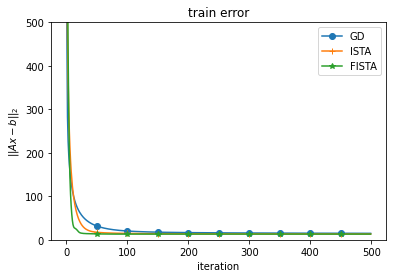

0.585148202763784
500  iteration and  0.001  regularization
4.321-smooth and 0.007-strongly-convex
min train error is 13.098
min test error is 312.542


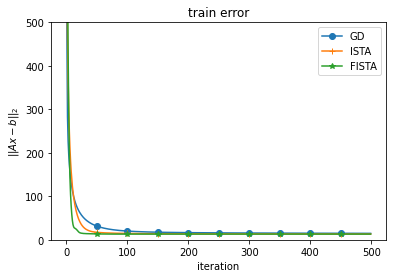

0.5852759708879791
500  iteration and  0.1  regularization
4.321-smooth and 0.007-strongly-convex
min train error is 14.971
min test error is 312.542


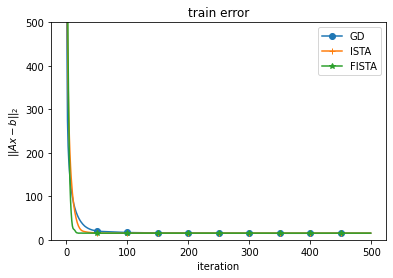

0.5854907364608397
500  iteration and  1.0  regularization
4.321-smooth and 0.007-strongly-convex
min train error is 18.374
min test error is 312.542


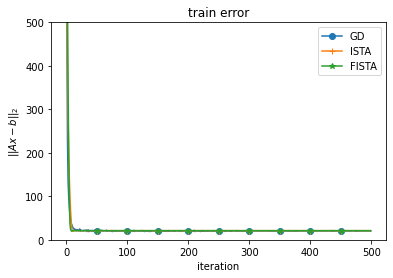

0.5858338093663362


In [ ]:
# main
def pIstaFista(T=int(1e4),reg=1e-1,R=5.):
    print(T,' iteration and ', reg, ' regularization')

    # data load and initialize
    X_tr=np.load('A.npy')
    y_tr=np.load('b.npy')
    #intialize empty test set
    X_te=np.zeros((1, X_tr.shape[1]))
    y_te=np.array((1, y_tr.shape[0]))
    sm , sc = (1/X_tr.shape[0])*la.norm(X_tr,2)**2,(1/X_tr.shape[0])*la.norm(X_tr,-2)**2
    numtr,numte=X_tr.shape[0],X_te.shape[0]
    print(f'{sm:0.3f}-smooth and {sc:0.3f}-strongly-convex')
    train=Data(X_tr,y_tr)
    test=Data(X_te,y_te)

    np.random.seed(1000)
    initbeta=np.random.rand(train.X.shape[1])*10
    var=Variable(initbeta,initbeta,0)

    params=Parameter(initbeta,var)
    params.numpts=train.X.shape[0]
    params.reg=reg
    params.max_iter=T

    name='pIstaFista'+'_reg_'+str(reg)+'_R_'+str(R)+'.eps'

    # gd
    params.stepsize=5e-1
    beta_gd,loss_gd,reg_gd,te_error_gd,elapsed_time_gd\
    =descent_p2(gd, func_linreg, grad_linreg,None,\
             train, test, params,fixedstep2)
    loss_gd=[np.sqrt(x*2*numtr) for x in loss_gd]
    te_error_gd=[np.sqrt(x*2*numte) for x in te_error_gd]

    #ista
    params.stepsize=1/sm
    beta_ista,loss_ista,reg_ista,te_error_ista,elapsed_time_ista\
    =descent_p2(ista, func_linreg, grad_linreg,None,\
             train, test, params,constantstep)
    loss_ista=[np.sqrt(x*2*numtr) for x in loss_ista]
    te_error_ista=[np.sqrt(x*2*numte) for x in te_error_ista]

    #fista
    params.stepsize=1/sm
    beta_fista,loss_fista,reg_fista,te_error_fista,elapsed_time_fista\
    =descent_p2(fista, func_linreg, grad_linreg,None,\
             train, test, params,constantstep)
    loss_fista=[np.sqrt(x*2*numtr) for x in loss_fista]
    te_error_fista=[np.sqrt(x*2*numte) for x in te_error_fista]

    loss=[loss_gd,loss_ista,loss_fista]
    te_error=[te_error_gd,te_error_ista,te_error_fista]
    algo=['GD','ISTA','FISTA']
    marker=['o','+','*','.']

    print(f'min train error is {min([min(x) for x in loss]):0.3f}')
    print(f'min test error is {min([min(x) for x in te_error]):0.3f}')

    plotresult(loss,algo,params,marker,title='train error',\
               ylabel=r'$||Ax-b||_2$',xlabel='iteration',\
               yscale='linear',isSave=False,filename='train_'+name,ylim=[0,5e2])

    print(la.norm(beta_fista-initbeta,2)/(sm*np.sqrt(T)))

if __name__ == "__main__":
    pIstaFista(T=int(5e2),reg=1e-5,R=5.)
    pIstaFista(T=int(5e2),reg=1e-3,R=5.)
    pIstaFista(T=int(5e2),reg=1e-1,R=5.)
    pIstaFista(T=int(5e2),reg=1e-0,R=5.)

# Problem 3: Optional -- Why we use LASSO

As an optional exercise, you may want to play around with Lasso and explore its properties in the context of machine learning problems.

To do this: (A) Generate data for yourself at random: create a $n \times d$ matrix $A$ where each entry comes from a standard Gaussian. Choose $d$ much larger than $n$, say, $d = 1000$ and $n = 100$. Now choose the true solution, $x^{\ast}$ to be a $k$-sparse vector. You can do this in many ways. One simple approach is to let $x^{\ast}$ equal 10 on $k=5$ randomly chosen entries, and then zero every where else. Finally, generate $y$ according to
$$
y = Ax + \epsilon,
$$
where $\epsilon$ is zero mean Gaussian noise with variance $0.1$.

Now solve (via an algorithm of your choice) Lasso. Note that you will have to search for a good value for $\lambda$. Compare the solution you get $\hat{x}_{\rm lasso}$ with the true solution, as you vary $\lambda$. You may also want to compare it to the solution when you do not have any regularization.


In [ ]:
d = 1000
n = 100
k = 5
A = np.random.normal(0, 1, size=(n,d))
eps = np.random.normal(0, np.sqrt(0.1), 100)
x = np.append(10*np.ones(k), np.zeros(d - k))
y = np.dot(A,x) + eps

def subgradient_lasso(x, A, b, t, lam, c=1e-4):
    grad_l1=np.sign(x)
    grad_l1[np.where(x==0)]=np.random.rand()*2-1
    grad=np.dot(A.T,np.dot(A,x)-b)+lam*grad_l1
    #eta=c/np.sqrt(t+1)
    eta = c/(t+1)
    y=x-eta*grad
    # to return the best solution
    if (0.5*np.square(la.norm(np.dot(A,y)-b,2))+lam*np.sum(abs(y))) < (0.5*np.square(la.norm(np.dot(A,x)-b,2))+lam*np.sum(abs(x))):
      x=y
    return x

def subgradient_leastsquares(x, A, b, t, lam, c=1e-4):
    grad=np.dot(A.T,np.dot(A,x)-b)
    eta = c/(t+1)
    y=x-eta*grad
    # to return the best solution
    if (0.5*np.square(la.norm(np.dot(A,y)-b,2))) < (0.5*np.square(la.norm(np.dot(A,x)-b,2))):
      x=y
    return x

def descent(update, A, b, reg, T=int(1e3)):
    x = np.zeros(A.shape[1])
    error = []
    l1 = []
    loss = []
    elapsed_time = []
    start=time.time()
    for t in range(T):
        x = update(x, A, b, t, reg)
        end=time.time()
        if (t % 1 == 0) or (t == T - 1):
            error.append(la.norm(np.dot(A, x) - b))
            l1.append(np.sum(abs(x)))
            loss.append(0.5*la.norm(np.dot(A, x) - b)+reg*np.sum(abs(x)))
            elapsed_time.append(end-start)
            assert not np.isnan(error[-1])
    return x, error, l1, elapsed_time, loss

T=int(1e4)
A, b = A, y

lam = 1e2

x_sg_l, error_sg_l, l1_sg_l, t_sg_l, loss_sg_l = descent(subgradient_lasso, A, b, reg=lam, T=T)
x_sg_ls, error_sg_ls, l1_sg_ls, t_sg_ls, loss_sg_ls = descent(subgradient_leastsquares, A, b, reg=lam, T=T)

In [ ]:
# try with various lam parameters above:
print(f'LASSO nonzero count:{np.sum(x_sg_l > 0.001)}, Least Squares nonzero count:{np.sum(x_sg_ls > 0.01)}')

LASSO nonzero count:256, Least Squares nonzero count:469


# Problem 4: Logistic Regression

Logistic regression is a simple statistical classification method which models
the conditional distribution of the class variable $y$ being equal to class $c$
given an input $x \in \mathbb{R}^n$. We will examine two classification tasks, one
classifying newsgroup posts, and the other classifying digits. In these tasks
the input $x$ is some description of the sample (e.g., word counts in the news
case) and $y$ is the category the sample belongs to (e.g., sports, politics).
The Logistic Regression model assumes the class distribution conditioned on $x$
is log-linear:
$$
p(y=c|x,b_{1:C}) = \frac{e^{-b_c^\top x}}{\sum_{j=1}^C e^{-b_j^\top x}},
$$
where $C$ is the total number of classes, and the denominator sums over all
classes to ensure that $p(y|x)$ is a proper probability distribution. Each
class $c \in {1,2, \dots, C}$ has a parameter $b_c$, and $\mathbf{b} \in
\mathbb{R}^{nC}$ is the vector of concatenated parameters $\mathbf{b} =
[b_1^\top,b_2^\top,\dots,b_C^\top]^\top$.  Let $X \in \mathbb{R}^{N \times n}$ be the
data matrix where each sample $x_i^\top$ is a row and $N$ is the number of
samples.  The maximum likelihood approach seeks to find the parameter
$\mathbf{b}$ which maximizes the likelihood of the classes given the input data
and the model:

$$
\max_{b_{1:C}} \; p(y|x,b_{1:C}) = \prod_{i=1}^N p(y_i|x_i,b_{1:C}) = \prod_{i=1}^N \frac{e^{-b_{y_i}^\top x_i}}{\sum_{j=1}^C e^{-b_j^\top x_i}}.
$$

For the purposes of optimization, we can equivalently minimize the negative log
likelihood:
$$
\min_\mathbf{\beta} \ell(\mathbf{\beta}) = -\log p(\textbf{y}|X, \mathbf{\beta}) = \sum_{i=1}^N \left( \beta_{y_i}^\top x_i + \log{\sum_{j=1}^C e^{-\beta_j^\top x_i}} \right).
$$

After optimization, the model can be used to classify a new input by choosing
the class that the model predicts as having the highest likelihood; note that
we don't have to compute the normalizing quantity $\sum_{j=1}^C e^{-b_j^\top x}$
as it is constant across all classes:
$$
y = \arg\max_j p(y=j| x, \mathbf{\beta}) = \arg\min_j \beta_j^\top x
$$
In this problem, you will optimize the logistic regression model for the two
classification tasks mentioned above which vary in dimension and number of
classes. The newsgroup dataset that we consider here has $C=20$.

We will compare the performance of gradient descent and Nesterov's accelerated gradient
method on the $\ell^2$-regularized version of the logistic regression model:
$$
\min_{\boldsymbol{\beta}} = \frac{1}{N} \sum_{i=1}^N \left( \beta_{y_i}^\top x_i + \log{\sum_{j=1}^C e^{-\beta_j^\top x_i}} \right) + \mu \|\boldsymbol{\beta}\|^2.
$$

In this homework, we will use the training and testing data contained in the four csv files in logistic\_news.zip. In a later homework, we will look into the digits dataset (MNIST).



## Part (A) -- Optional --
Find the value of $\mu$ that gives you (approximately) the best generalization performance (error on test set). You obtain this by solving the the above optimization problem for different values of $\mu$, and then checking the performance of the solution on the testing set, using the unregularized logistic regression loss. Note that this is not a question about an optimization method.

What value do you get for the test loss after convergence?

## Part (B)

If you did Part (A), use the value of $\mu$ you found there. If you did not, use $\mu = 0.001$.

Plot the loss against iterations for both the test and training data
using the value of $\mu$ from part (a).

## Part (C)

How do the two algorithms differ in performance, and how does this change
as you decrease $\mu$?

In [ ]:
import zipfile as zipfile

from sklearn.datasets import fetch_20newsgroups
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [ ]:
def gd(var,data,func,grad,hess,linesearch,iter,params):
    numpts=params.numpts
    beta=var.beta
    desc=-np.sum(grad(beta,data,params,numpts),axis=0)
    eta=linesearch(beta,func,grad,desc,data,params,iter)
    beta=beta+eta*desc
    var=Variable(beta,beta,0)
    return var

def agd(var,data,func,grad,hess,linesearch,iter,params):
    numpts=params.numpts
    beta,gamma,tau=var.beta,var.gamma,var.tau
    tau_old=tau
    tau=(1+np.sqrt(1+4*np.square(tau)))/2
    ratio=(1-tau_old)/tau
    beta_old=beta
    gamma_old=gamma
    desc=-np.sum(grad(beta,data,params,numpts),axis=0)
    eta=linesearch(beta,func,grad,desc,data,params,iter)
    gamma=beta+eta*desc
    beta=(1-ratio)*gamma+ratio*(gamma_old)
    var=Variable(beta,gamma,tau)
    return var

In [ ]:
# logistic regression with two classes
def func_logreg(beta,data,params,numpts):
    n,d=data.X.shape
    if numpts==n:
        X,Y=data.X,data.Y
        loss=(1./Y.shape[0])*np.sum(np.log(1.+np.exp(np.dot(X,beta)*(-Y))))
        reg=params.reg*np.sum(beta**2)
        return loss,reg
    elif numpts==1:
        idx=params.idx
        X,Y=data.X[idx,:],data.Y[idx]
        loss=np.log(1.+np.exp(np.dot(X,beta)*(-Y)))
        reg=params.reg*np.sum(beta**2)
        return loss,reg
    else:
        print('error')

def grad_logreg(beta,data,params,numpts):
    n,d=data.X.shape
    if numpts==n:
        X,Y=data.X,data.Y
        g_loss=(1./Y.shape[0])*np.dot(X.T,-Y*(1./(1.+np.exp(np.dot(X,beta)*Y))))
        g_reg=2*params.reg*beta
        return g_loss,g_reg
    elif numpts==1:
        idx=params.idx
        X,Y=data.X[idx,:],data.Y[idx]
        g_loss=X.T*(-Y*(1./(1.+np.exp(np.dot(X,beta)*Y))))
        g_reg=2*params.reg*beta
        return g_loss,g_reg
    else:
        print('error')

In [ ]:
# logistic Regression with multi classes
def func_logreg_multiclass(beta,data,params,numpts):
    n,d=data.X.shape
    if numpts==n:
        X,Y,Z=data.X,data.Y,data.Z
        loss=(1./Y.shape[0])*(np.trace(np.dot(beta.T,Z))+np.sum(np.log(np.sum(np.exp(-np.dot(X,beta)),axis=1))))
        reg=params.reg*la.norm(beta,'fro')**2
        return loss,reg
    elif numpts==1:
        idx=params.idx
        X,Y=data.X[idx,:],data.Y[idx]
        loss=np.dot(beta[:,Y],X)+np.log(np.sum(np.exp(-np.dot(beta.T,X))))
        reg=params.reg*la.norm(beta,'fro')**2
        return loss,reg
    else:
        print('error')
def grad_logreg_multiclass(beta,data,params,numpts):
    n,d=data.X.shape
    if numpts==n:
        X,Y,Z=data.X,data.Y,data.Z
        weight=(np.exp(-np.dot(X,beta)).T/np.sum(np.exp(-np.dot(X,beta)),axis=1)).T
        g_loss=(1./Y.shape[0])*(Z+np.dot(-X.T,weight))
        g_reg=2*params.reg*beta
        return g_loss,g_reg
    elif numpts==1:
        idx=params.idx
        X,Y=data.X[idx,:],data.Y[idx]
        Z=np.zeros(beta.shape)
        Z[:,Y]=X.T
        weight=np.exp(-np.dot(beta.T,X.T))/np.sum(np.exp(-np.dot(beta.T,X.T)))
        g_loss=Z+np.outer(-X,weight)
        g_reg=2*params.reg*beta
        return g_loss,g_reg
    else:
        print('error')

In [ ]:
def loaddata(filename):
    import io
    data=[]
    with zipfile.ZipFile(filename) as z:
        for filename in z.namelist():
            if filename[0]=='X'or filename[0]=='y':
                each=[]
                with z.open(filename) as csvDataFile:
                    csvReader=csv.reader(csvDataFile)
                    csvDataFile_utf8 = io.TextIOWrapper(csvDataFile, 'utf-8')
                    csvReader=csv.reader(csvDataFile_utf8)
                    for row in csvReader:
                        each.append(row)
                    each==[[float(string) for string in row] for row in each]
                    each=np.asarray(each)
                    data.append(each)
    X_te=data[0].astype(float)
    X_tr=data[1].astype(float)
    y_te=data[2][0].astype(int)
    y_tr=data[3][0].astype(int)
    Z_tr,Z_te=[],[]
    for j in range(len(np.unique(y_tr))):
        Z_tr.append(np.sum(X_tr[np.where(y_tr==j)[0],:],axis=0))
        Z_te.append(np.sum(X_te[np.where(y_te==j)[0],:],axis=0))
    Z_tr=np.asarray(Z_tr).T
    Z_te=np.asarray(Z_te).T
    train= Data(X_tr,y_tr)
    train.Z=Z_tr
    test = Data(X_te,y_te)
    test.Z=Z_te
    return train,test

1000  iterations and  0.001  reg and  0.1  stepsize
starting gradient descent...
starting accelerated gradient descent...
min train error is  2.6904920318450927
min test error is 2.7219241450487033


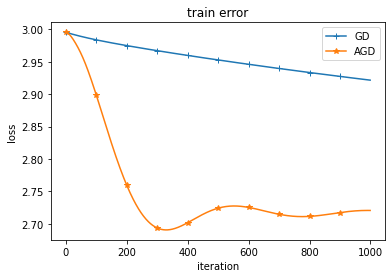

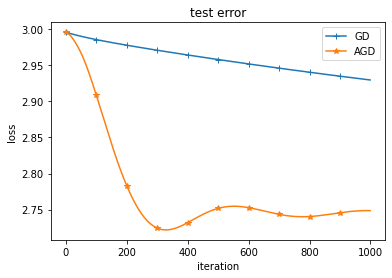

In [ ]:
def pLogistic(T=int(1e2),reg=1e-1,stepsize=1e-1):
    print(T,' iterations and ',reg, ' reg and ', stepsize,' stepsize')
    # load data and intialize
    train,test=loaddata('./logistic_news.zip')

    np.random.seed(1000)
    initbeta=np.zeros(train.Z.shape)
    var=Variable(initbeta,initbeta,0)

    params=Parameter(initbeta,var)
    params.numpts=train.X.shape[0]
    params.reg=reg
    params.max_iter=T

    name='pLogistic_reg_'+str(reg)+'_step_'+str(stepsize)+'.eps'


    #gd
    print('starting gradient descent...')
    params.stepsize=stepsize
    beta_gd,loss_gd,reg_gd,te_error_gd,elapsed_time_gd=descent_p2(gd, func_logreg_multiclass, grad_logreg_multiclass, None,train, test, params,constantstep)
    #agd
    print('starting accelerated gradient descent...')
    params.stepsize=stepsize
    beta_agd,loss_agd,reg_agd,te_error_agd,elapsed_time_agd=descent_p2(agd, func_logreg_multiclass, grad_logreg_multiclass,None,train, test, params,constantstep)

    loss=[loss_gd,loss_agd]
    te_error=[te_error_gd,te_error_agd]
    algo=['GD','AGD']
    marker=['+','*']

    print('min train error is ',min([min(x) for x in loss]))
    print('min test error is',min([min(x) for x in te_error]))

    plotresult(loss,algo,params,marker,title='train error',\
               ylabel='loss',xlabel='iteration',\
               yscale='linear',isSave=False,filename='train_'+name)
    plotresult(te_error,algo,params,marker,title='test error',\
               ylabel='loss',xlabel='iteration',\
               yscale='linear',isSave=False,filename='test_'+name)

if __name__ == "__main__":
    pLogistic(T=int(1e3),reg=1e-3,stepsize=1e-1)
#    pLogistic(T=int(50),reg=1e-3,stepsize=1e-2)
#    pLogistic(T=int(100),reg=1e-3,stepsize=1e-2)
#    pLogistic(T=int(1e3),reg=1e-3,stepsize=1e-3)

Note that AGD is not a descent algorithm. Nevertheless, it has significantly better performance compared to gradient descent.